In [1]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
import talib
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from backtesting import Backtest, Strategy
from bokeh.plotting import figure, show
import numpy as np
from backtesting import Backtest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from backtesting.test import EURUSD, SMA

N_TRAIN = 400


def prepare_features(data):
    # Calculate WMA
    data['WMA'] = talib.WMA(data.Close, timeperiod=3)
    
    # Create lagged WMA features
    for i in range(1, 6):
        data[f'WMA_t-{i}'] = data['WMA'].shift(i)
    return data

def get_X(data):
    """Return model design matrix X"""
    X_columns = data.filter(like='WMA').columns
    
    # Combine OHLC columns with 'X' columns
    all_columns = ['Open', 'High', 'Low', 'Close'] + list(X_columns)
    return data[all_columns].values

def get_y(data):
    """Return dependent variable y as WMAt+1"""
    # Shift WMA by -1 to get the next day's WMA (WMAt+1) difference
    return data['WMA'].shift(-1) - data['WMA']


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    
    # Ensure X and y have the same number of samples
    min_samples = min(len(X), len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    
    # Remove NaN values
    isnan = np.isnan(y) | np.isnan(X).any(axis=1)
    X = X[~isnan]
    y = y[~isnan]
    
    return X, y


data = EURUSD.copy()
data = prepare_features(data)

class EnhancedBollingerBandStrategy(Strategy):
    n=20
    k=3

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = RandomForestRegressor(max_depth=7, n_estimators=10, random_state=0)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        X = X[:-1]
        y = y[:-1]
        X = X[:N_TRAIN]
        y = y[:N_TRAIN]
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator of the length of data
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
        
        self.upper, self.middle, self.lower = self.I(talib.BBANDS, self.data.Close, timeperiod=self.n, nbdevup=self.k, nbdevdn=self.k)
        
        self.atr = self.I(talib.ATR, self.data.High, self.data.Low, self.data.Close, timeperiod=self.n)

    def next(self):
        if len(self.data) < N_TRAIN:
            return

        X = get_X(self.data.df.iloc[-1:])
        predicted_wma_change = self.clf.predict(X)[0]
        predicted_wma = self.data.WMA[-1] + predicted_wma_change

        upper = self.upper[-1]
        lower = self.lower[-1]
        atr = self.atr[-1]
        close = self.data.Close[-1]

        if not self.position:
            if predicted_wma <= lower:
                self.buy()
            elif predicted_wma >= upper:
                self.sell()
        elif self.position.is_long:
            if predicted_wma < close - 3 * atr:
                self.position.close()
            elif predicted_wma > upper:
                self.position.close()
        elif self.position.is_short:
            if predicted_wma > close + 3 * atr:
                self.position.close()
            elif predicted_wma < lower:
                self.position.close()

/Users/bread/opt/anaconda3/envs/ml4t/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## The following code is independent of the backtesting strategy and is designed to execute a fixed-period strategy across all stocks (in an unoptimized fashion as of now)

  0%|          | 0/5 [00:00<?, ?it/s]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                     Start                  End                      Duration  \
count                    5                    5                             5   
mean   2005-10-20 14:24:00  2023-12-29 00:00:00            6643 days 09:36:00   
min    2004-01-02 00:00:00  2023-12-29 00:00:00            4013 days 00:00:00   
25%    2004-01-02 00:00:00  2023-12-29 00:00:00            7301 days 00:00:00   
50%    2004-01-02 00:00:00  2023-12-29 00:00:00            7301 days 00:00:00   
75%    2004-01-02 00:00:00  2023-12-29 00:00:00            7301 days 00:00:00   
max    2013-01-02 00:00:00  2023-12-29 00:00:00            7301 days 00:00:00   
std                    NaN                  NaN  1470 days 10:31:09.293133648   

       Exposure Time [%]  Equity Final [$]  Equity Peak [$]   Return [%]  \
count           5.000000          5.000000         5.000000     5.000000   
mean           35.144049      53831.530728     58101.198991   438.315307   
min             0.000000      10000.000000

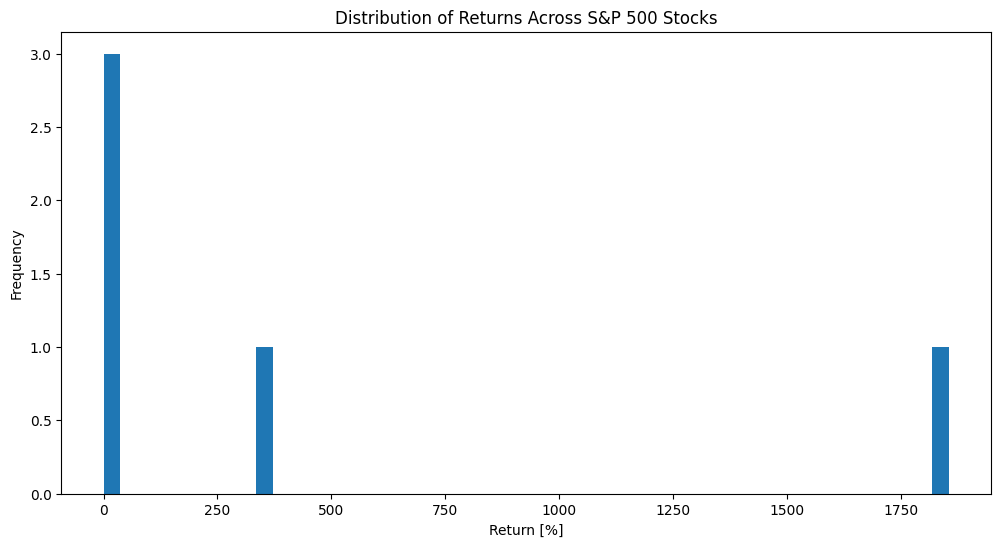


MLflow Tracking URI: sqlite:///mlflow2.db
Use 'mlflow ui' command to view detailed results in the MLflow UI


In [3]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
import talib
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import warnings
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import os
from datetime import datetime
import re

warnings.filterwarnings('ignore')

# Global variables
N_TRAIN = 400
START_DATE = "2004-01-01"
END_DATE = "2023-12-31"
EXPERIMENT_NAME = "MLflow_6"

# Main execution
# Set MLflow tracking URI (adjust as needed)
mlflow.set_tracking_uri("sqlite:///../../../mlflow2.db")
a
mlflow.set_experiment(f"{EXPERIMENT_NAME}_{START_DATE}_to_{END_DATE}")

def run_backtest(ticker):
    try:
        # Download data
        data = yf.download(ticker, start=START_DATE, end=END_DATE)
        if len(data) < N_TRAIN:
            return None

        # Prepare features
        data = prepare_features(data)

        # Run backtest
        bt = Backtest(data, EnhancedBollingerBandStrategy, cash=10000, commission=.002)
        result = bt.run()

        result['Ticker'] = ticker
        return result

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return None


def log_results_to_mlflow(result):
    if result is None:
        return

    ticker = result['Ticker']

    # Log parameters
    mlflow.log_param("start_date", START_DATE)
    mlflow.log_param("end_date", END_DATE)
    mlflow.log_param("bollinger_period", EnhancedBollingerBandStrategy.n)
    mlflow.log_param("bollinger_std", EnhancedBollingerBandStrategy.k)
    
    # Log all scalar metrics from the result
    for key, value in result.items():
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            mlflow.log_metric(re.sub(r'[^a-zA-Z0-9]', '', key.lower()), value)

    # Log equity curve
    plt.figure(figsize=(10, 6))
    result['_equity_curve']['Equity'].plot()
    plt.title(f'Equity Curve - {ticker}')
    plt.tight_layout()
    equity_curve_path = f"{ticker}_equity_curve.png"
    plt.savefig(equity_curve_path)
    plt.close()
    mlflow.log_artifact(equity_curve_path)
    os.remove(equity_curve_path)  # Clean up the file after logging

# Get S&P 500 tickers
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]
    return table['Symbol'].tolist()


if __name__ == "__main__":
    tickers = get_sp500_tickers()[:5]
    results = []
    for ticker in tqdm(tickers):  # Sequential execution
        # mlflow.set_experiment(f"{EXPERIMENT_NAME}_{ticker}_{START_DATE}_to_{END_DATE}")
        with mlflow.start_run(run_name=f"{EXPERIMENT_NAME}_{ticker}_{START_DATE}_to_{END_DATE}"):
            result = run_backtest(ticker)
            if result is not None:
                results.append(result)
                log_results_to_mlflow(result)
            

    if results:
        # Convert results to DataFrame and save
        results_df = pd.DataFrame(results)
        results_df.to_csv('sp500_enhanced_bollinger_results.csv', index=False)
        
        # Print summary statistics
        print(results_df.describe())
        
        # Identify top performing stocks
        top_performers = results_df.nlargest(10, 'Return [%]')
        print("\nTop 10 Performing Stocks:")
        print(top_performers)
        
        # Identify worst performing stocks
        worst_performers = results_df.nsmallest(10, 'Return [%]')
        print("\nBottom 10 Performing Stocks:")
        print(worst_performers)
        
        # Plot overall distribution of returns
        plt.figure(figsize=(12, 6))
        plt.hist(results_df['Return [%]'], bins=50)
        plt.title('Distribution of Returns Across S&P 500 Stocks')
        plt.xlabel('Return [%]')
        plt.ylabel('Frequency')
        returns_dist_path = 'sp500_returns_distribution.png'
        plt.savefig(returns_dist_path)
        plt.show()
        
        # Log overall results as a separate experiment
        # mlflow.set_experiment(f"{EXPERIMENT_NAME}_S&P500_Overall_Results")
        with mlflow.start_run(run_name=f"{EXPERIMENT_NAME}_S&P500_Overall_Results"):
            mlflow.log_param("total_stocks", len(results_df))
            mlflow.log_param("start_date", START_DATE)
            mlflow.log_param("end_date", END_DATE)
            mlflow.log_metric("mean_return", results_df['Return [%]'].mean())
            mlflow.log_metric("median_return", results_df['Return [%]'].median())
            mlflow.log_metric("mean_sharpe", results_df['Sharpe Ratio'].mean())
            
            # Log distribution plot
            mlflow.log_artifact(returns_dist_path)
            os.remove(returns_dist_path)  # Clean up the file after logging
        
            # Log results CSV
            mlflow.log_artifact('sp500_enhanced_bollinger_results.csv')
        
        # Print MLflow tracking URI
        print(f"\nMLflow Tracking URI: {mlflow.get_tracking_uri()}")
        print("Use 'mlflow ui' command to view detailed results in the MLflow UI")
